In [ ]:
clear
pkg load statistics

## **Loading and Creation Data**


#### *loadFunctionFromData*
This function permits to load large sparse matrix from [https://sparse.tamu.edu/](https://sparse.tamu.edu/).

In [2]:
function A = loadFunctionFromData(dataPath)
    disp(["🦍 Loading file: "  dataPath])
    load(dataPath)
    
%   se nel file è presente una `struct` allora vuol dire 
%   che sto utilizzando il nuovo formato e va convertito
%   per essere utilizzato da Octave
    if isstruct(Problem.A)
        n = length(Problem.A.jc)-1;
        ii = repelems(1:n, [1:n; diff(Problem.A.jc)]);
        A = sparse(Problem.A.ir+1, ii, Problem.A.data);
    else
        A = Problem.A;
    end
endfunction

##### Example of loadFunctionFromData usage

In [3]:
% Esempio di come utilizzare la precedente funzione
% whos
% A = loadFunctionFromData('./data/cage15.mat');
% columns(A)
% rows(A)
% clear
% A = loadFunctionFromData('./data/vas_stokes_2M.mat');
% columns(A)
% rows(A)

### **generateData**
This function permit to create (randomly), the initial data for GMRES:
- `A`: the sparse coefficient matrix of the Linear System
- `b`: the known therm vector
- `x0`: initial guess

In [4]:
function [A b x0] = generateData(dim, den, seed=69, randx0=false)
    rand("seed", seed);
    A = sprand(dim, dim, den);
    b = rand(dim, 1);
    
    if (randx0)
        x0 = rand(dim, 1);
    else
        x0 = zeros(dim, 1);
    end
endfunction

### **generateData2**
This function permit to create (randomly), the initial data for GMRES using some conditioning in order to obtain convergence for sure:
- `A`: the coefficient matrix of the Linear System
- `b`: the known therm vector
- `x0`: initial guess

In [ ]:
function [A b x0] = generateData2(dim, n=-4, seed=69, randx0=false)
    rand("seed", seed);
    mu = 0;
    sigma = 1/(2*sqrt(dim));
    A = n * eye(dim) + normrnd(mu, sigma, dim);
    b = ones(dim, 1);

    if (randx0)
        x0 = rand(dim, 1);
    else
        x0 = zeros(dim, 1);
    end
endfunction

### **generateData3**
This function permit to create (randomly), the initial data for GMRES using some conditioning in order to obtain convergence for sure:
- `A`: the **sparse** coefficient matrix of the Linear System
- `b`: the known therm vector
- `x0`: initial guess

In [ ]:
function [A b x0] = generateData3(dim, dense, n=-4, seed=69, randx0=false)
    rand("seed", seed);

    A = sprandn(dim, dim, dense)*0.01 + speye(dim)*n ;
    b = ones(dim, 1);

    if (randx0)
        x0 = rand(dim, 1);
    else
        x0 = zeros(dim, 1);
    end

endfunction

### **Auxiliary functions**

#### *plotResiduals*
Function to plot residual.

In [ ]:
function plotResiduals(res, all=false)
    if (all)
        figure();
        plot(res);
        title("Residual over Iteration");
        xlabel("Iterations");
        ylabel("Residual Values");
    end

    figure();
    semilogy(res);
    title("Residual over Iteration (semilog scale)");
    xlabel("Iterations");
    ylabel("Residual Values");

endfunction

#### *plotFunction*
Auxiliary functions to plot matrix and eigenvalue informations.

In [ ]:
function plotMatrix(A, figTitle="Matrix")
    figure();
    imagesc(A(1:50, 1:50));
    colorbar();
    title(figTitle);
endfunction

function plotEig(A, figTitle="Eigenvalues")
    figure();
    plot(eig(A), 'o');
    title(figTitle);
endfunction

function matrixInfo(A, title1="Matrix", title2="Eigenvalues")
    %plotMatrix(A, title1);

    plotEig(A, title2);
endfunction

## **GMRES implementation**

In [3]:
function [x res] = mygmres(A, b, x0, k, tol)
    n = size(b)(1);
    r0 = b - A * x0;
    beta = norm(r0, 2);
    
    H = zeros(k+2, k+1);
    Q = zeros(n, k+1);
    Q(:, 1) = r0/norm(r0, 2);
    
    en = zeros(k+2, 1);
    en(1) = 1;
        
    for j = 1:k
        v = A*Q(:, j);  
        
        % ortogonalizzazione
        for _ = 1:2
            for i = 1:j
                tmp = Q(:,i)' * v;
                v = v - tmp * Q(:, i);
                H(i,j) += tmp;
            end
        end

        H(j+1, j) = norm(v, 2);
        
        % TODO: capire come gestire la divisone per 0
        if (H(j+1, j) == 0)
            error("Divisione per 0 !!");
        end
        
        Q(:, j+1) = v / H(j+1, j);

        e1 = en(1:j+2);
        
        y =(H(1:j+2,1:j+1))\(beta *e1);
        res(j) = norm(H(1:j+2,1:j+1)*y - beta*e1, 2);

        if (res(j) < tol)
            disp(size(H));
            x = Q(:, 1:j+1)*y +x0;
            printf('🚀 Raggiunta Tolleranza (j: %d), stop', j);
            figure();
            imagesc(H(1:j, 1:j));
            colorbar();
            title("Matrix H");
            return;
        end
    end
    
    x = Q(:, 1:j+1)*y +x0;
    disp('🐌 Raggiunto massimo numero di Iterazioni');
    disp(size(H));
    figure();
    imagesc(H);  % TODO: plottare meglio
    colorbar();
    title("Matrix H");
endfunction

### **GMRES with Restarting**

In [ ]:
function [x res] = gmres_restarting(A, b, x0, k, tol, m)
    restartCount = 0;
    res = [];
    n = size(b)(1);
    en = zeros(k+2, 1);
    en(1) = 1;

    while (restartCount < m)
        H = zeros(k+2, k+1);
        Q = zeros(n, k+1);

        r0 = b - A * x0;
        beta = norm(r0, 2);
        Q(:, 1) = r0/norm(r0, 2);

        for j = 1:k
            v = A*Q(:, j);  

            % ortogonalizzazione
            for _ = 1:2
                for i = 1:j
                    %H(i,j) = Q(:,i)' * v;
                    tmp = Q(:,i)' * v;
                    v = v - tmp * Q(:, i);
                    H(i,j) += tmp;
                end
            end

            % ortogonalizzazione ??
            %v = mgorth(v, Q); %% è quella bella
    %         v = gramschmidt(v);

            H(j+1, j) = norm(v, 2);

            % TODO: capire come gestire la divisone per 0
            if (H(j+1, j) == 0)
                error("Divisione per 0 !!");
            end

            Q(:, j+1) = v / H(j+1, j);

            e1 = en(1:j+2);

            y =(H(1:j+2,1:j+1))\(beta *e1);
            res = [res norm(H(1:j+2,1:j+1)*y - beta*e1, 2)];

            if (res(end) < tol)
                x = Q(:, 1:j+1)*y +x0;
                disp('🚀 Raggiunta Tolleranza, stop');
                imagesc(H(1:j, 1:j));
                return;
            end
        end
        
        x = Q(:, 1:j+1)*y +x0;
        x0 = x;
        restartCount = restartCount + 1;
        
        disp('🐌 Raggiunto massimo numero di Iterazioni');
        disp('🗿 Restarting ...');
%         imagesc(H);
    end
    
    disp('❌ Raggiunto massimo numero di Restart');
    imagesc(H);
endfunction

## **TESTS**

### **Test 1** - Random Matrix

Little GMRES test using random data

In [7]:
[A, b, x0] = generateData(300, .5);

GMRES with iteration and tol = 1e-10.

🐌 Raggiunto massimo numero di Iterazioni
   52   51


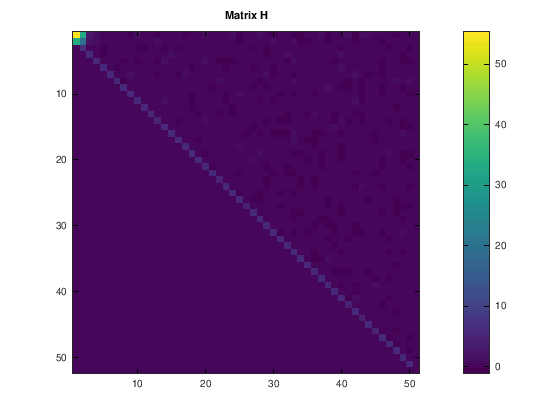

In [8]:
[x, res] = mygmres(A, b, x0, 50, 1e-10);

#### **Residual plot**

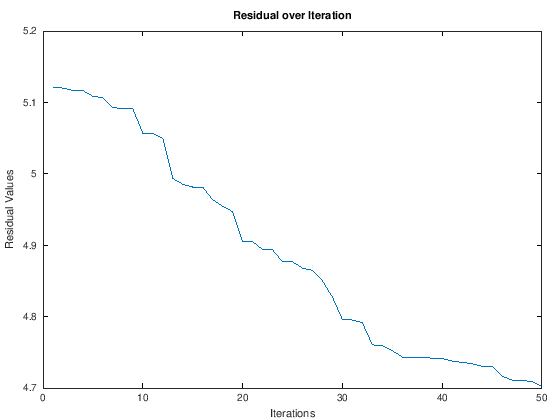

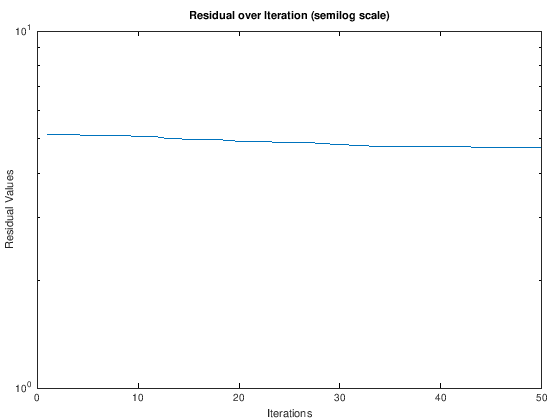

In [10]:
figure();
plot(res);
title("Residual over Iteration");
xlabel("Iterations");
ylabel("Residual Values");

figure();
semilogy(res);
title("Residual over Iteration (semilog scale)");
xlabel("Iterations");
ylabel("Residual Values");


We can see that in this execution GMRES is not able to converge.

**Now we can try to iterate for n iteration with n equal to A dimension and verify that GMRES converge to an exact solution.**

In [ ]:
[x, res] = mygmres(A, b, x0, 300, 1e-10);
approx_error = norm(x_true-x, 2)

plotResiduals(res);

### **Test 2**

**We can explore deeper the matrix composition, in order to see which common property they are**.

Generate 4 different linear systems with a dimension between [50, 800] (in order to obtain a fast eigenvalue computation).

In [ ]:
for _ = 1:4
    % 50 <= random size <= 800
    dim = randi([50 800], 1, 1);
    
    [A, b, x0] = generateData(dim, .5);
    
    matrixInfo(
        A, 
        title1=["Random Matrix of Size: " num2str(dim)], 
        title2=["Eigenvalue Random Matrix of Size: " num2str(dim)]
    );
end

### **Test 3**

Apply GMRES to a linear system with A that corresponds to identity matrix.

error: Divisione per 0 !!
error: called from
    mygmres at line 29 column 13


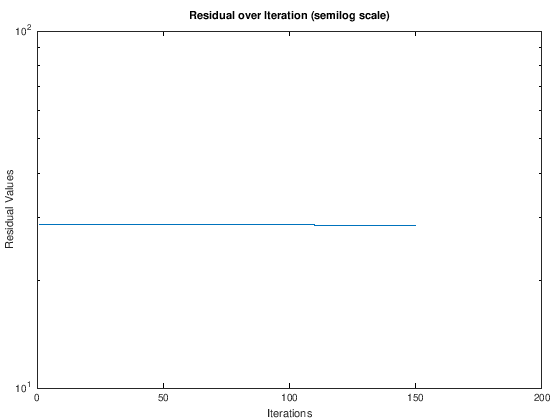

In [53]:
[A, b, x0] = generateData(300, .5);
A = eye(300);

[x, res] = mygmres(A, b, x0, 150, 1e-10);

plotResiduals(res);

### **Test 4**

GMRES with multiple of identity matrix.

In [ ]:
A = eye(300) * 5;

[x, res] = mygmres(A, b, x0, 150, 1e-10);

plotResiduals(res);
matrixInfo(A);

### **Test 5**

Random matrix + multiple of identity matrix.

🐌 Raggiunto massimo numero di Iterazioni


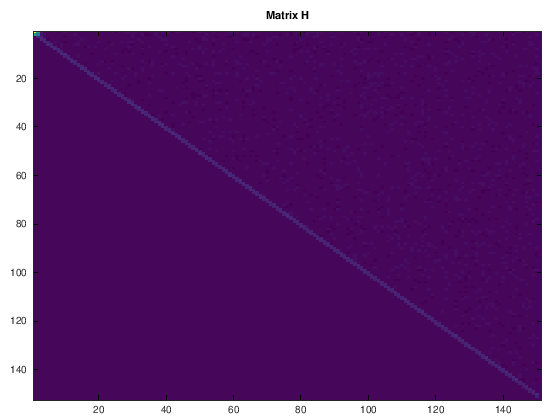

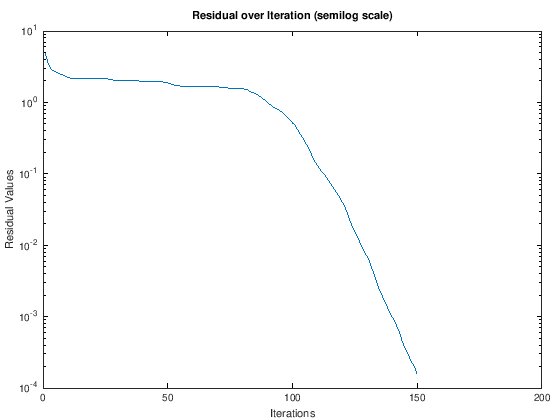

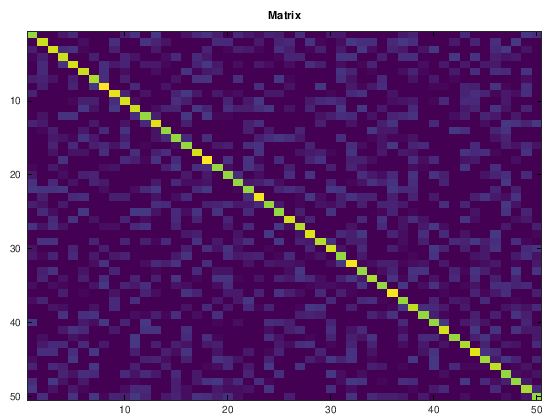

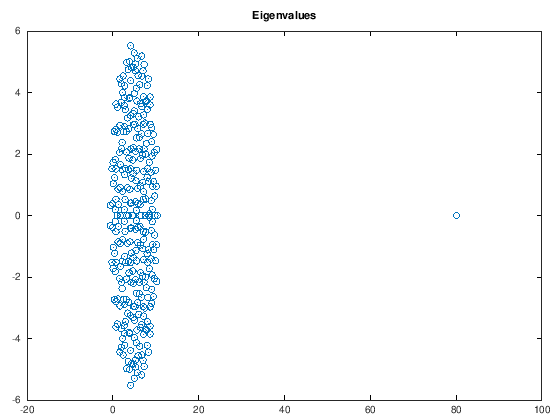

In [20]:
[A, b, x0] = generateData(300, .5);
A = A + eye(300)*5;

[x, res] = mygmres(A, b, x0, 150, 1e-10);

plotResiduals(res);
matrixInfo(A);

### **Test 6**

Use generateData2.

In [ ]:
for n = [-4 0 4]
%     printf("🍌 n = %d\n", n)
    
    [A, b, x0] = generateData2(300, n=n);
    [x, res] = mygmres(A, b, x0, 150, 1e-15);
    
    x_true = A\b;
    approx_error = norm(x_true-x, 2)
    
    plotEig(A, figTitle=["Eigenvalues Matrix of Size: " num2str(n)]);
    plotResiduals(res);
end

## **Big Data**

Try GMRES with large sparse matrix.

In [30]:
%%time
[A, b, x0] = generateData(10000, .5);

🐌 Raggiunto massimo numero di Iterazioni


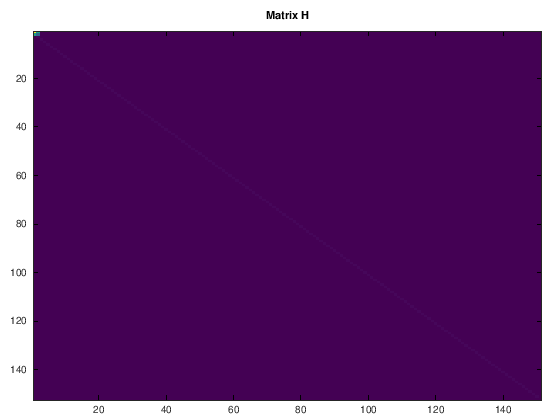

Time: 21.308188676834106 seconds.



In [31]:
%%time
[x, res] = mygmres(A, b, x0, 150, 1e-10);

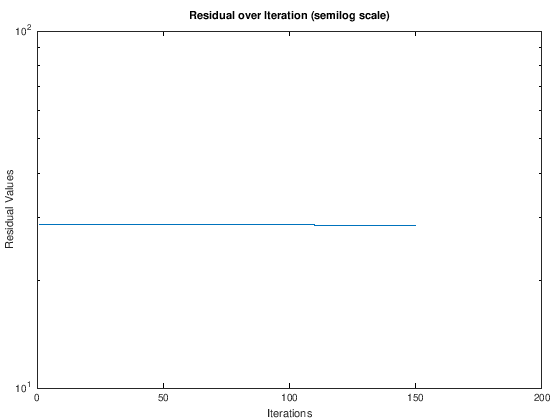

In [32]:
plotResiduals(res);

Now we are going to use `generateData3` function in order to generate large sparse matrices with which gmres converges (with `generateData2` the matrix is not sparse and it cannot be entered into memory).

In [39]:
%%time
[A b x0] = generateData3(100000, .1);

Time: 146.6969826221466 seconds.



ans =

   100000   100000

🚀 Raggiunta Tolleranza, stop


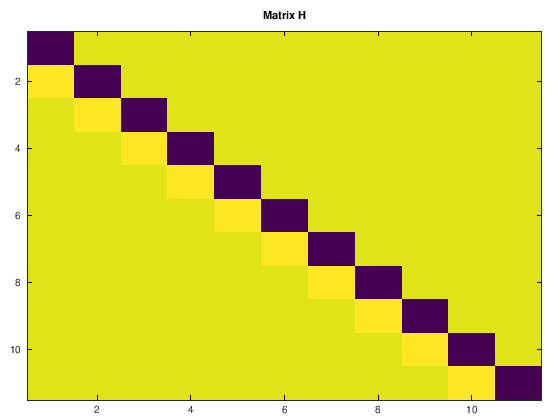

Time: 2.3716518878936768 seconds.



In [40]:
%%time
size(A)
[x, res] = mygmres(A, b, x0, 150, 1e-10);

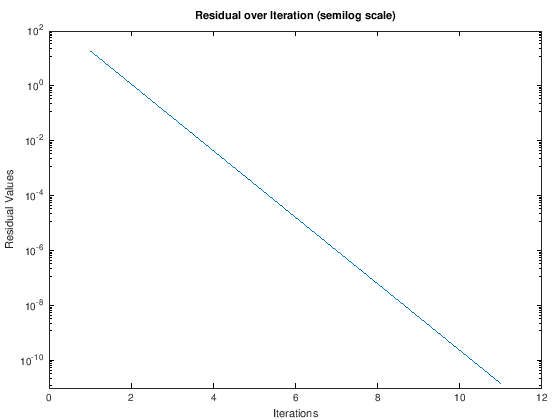

In [41]:
plotResiduals(res);

# **TO COMPLETE**

Provo con una matrice presa da sparse.edu

**Non funziona**

In [4]:
%%time
A = loadFunctionFromData("../data/europe_osm.mat");
b = ones(size(A)(1));
x0 = zeros(size(A)(1));

🦍 Loading file: ../data/europe_osm.mat
error: out of memory or dimension too large for Octave's index type
error: out of memory or dimension too large for Octave's index type
Time: 9.685840606689453 seconds.



In [14]:
size(A)

ans =

   14734   14734



In [5]:
%%time
[x, res] = mygmres(A, b, x0, 150, 1e-10);


Restarting kernel...
Done!


[Errno 9] Bad file descriptor


Time: 46.07128024101257 seconds.



In [ ]:
plotResiduals(res);

## GMRES(m)

Implementazion di GMRES con Restarting e vari test.

🚀 Raggiunta Tolleranza, stop


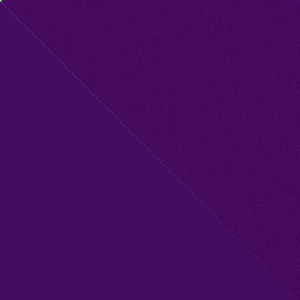

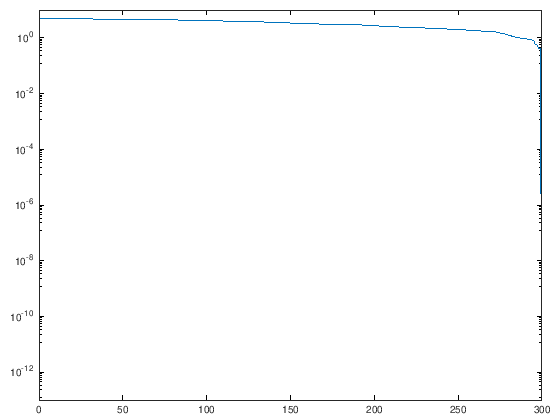

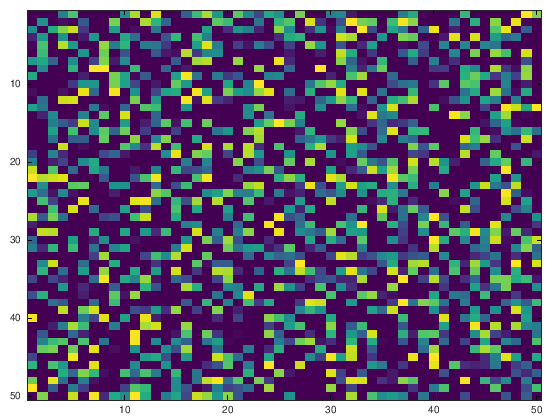

In [40]:
[A, b, x0] = generateData(9000, .5);

figure();
[x, res] = myrgmres(A, b, x0, 150, 1e-10, 10);

figure();
semilogy(res);

figure();
imagesc(A(1:50, 1:50));

🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🚀 Raggiunta Tolleranza, stop
ans =    1.3054e-09


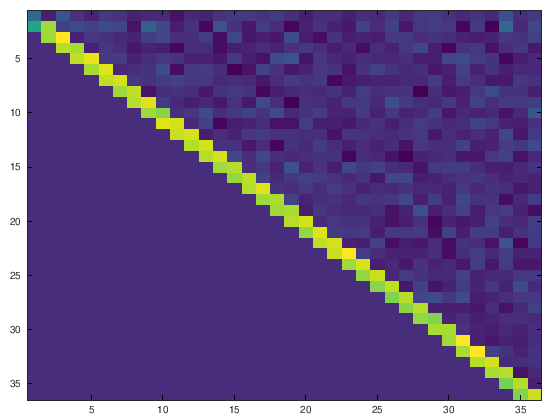

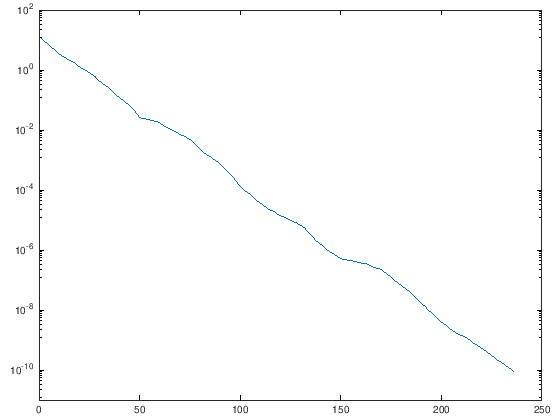

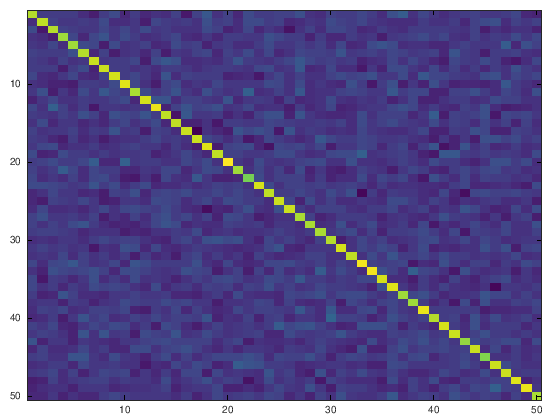

In [55]:
%questo è gustoso 🚀
[A, b, x0] = generateData2(300, .5);
figure();
[x, res] = myrgmres(A, b, x0, 50, 1e-10, 10);

figure();
semilogy(res);

figure();
imagesc(A(1:50, 1:50));

x_true = A\b;
norm(x_true-x, 2)

🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
❌ Raggiunto massimo numero di Restart
ans =  68.967


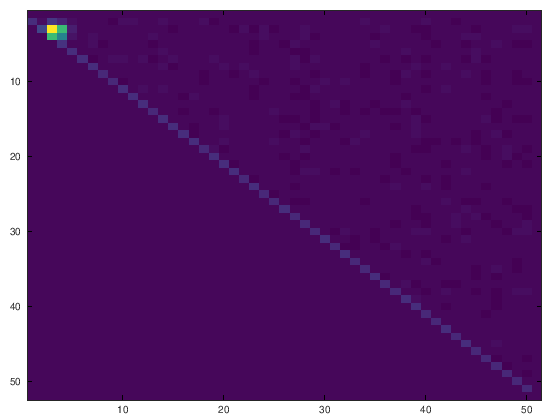

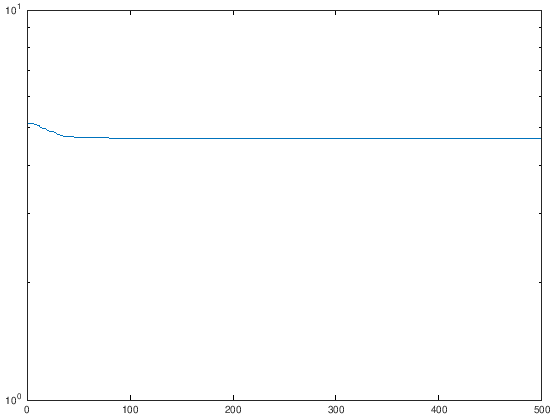

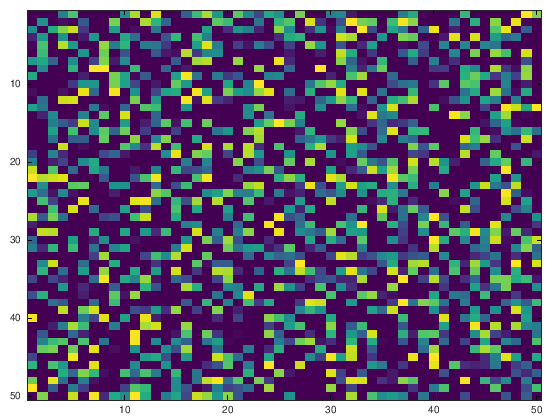

In [41]:
[A, b, x0] = generateData(300, .5);

figure();
[x, res] = myrgmres(A, b, x0, 50, 1e-10, 10);

figure();
semilogy(res);

figure();
imagesc(A(1:50, 1:50));

x_true = A\b;
norm(x_true-x, 2)

In [57]:
x_true = A\b;
norm(x_true-x, 2)

ans =  295.03


🚀 Raggiunta Tolleranza, stop
ans =    1.2095e-11


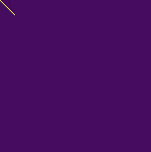

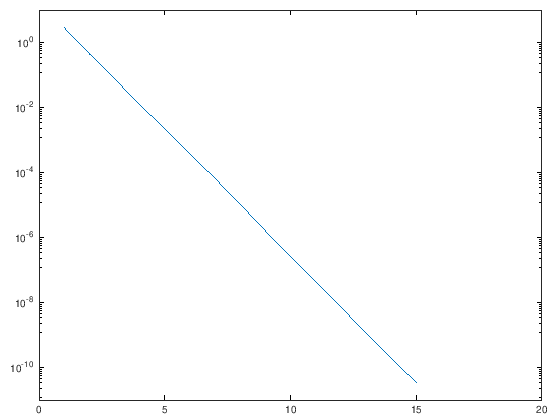

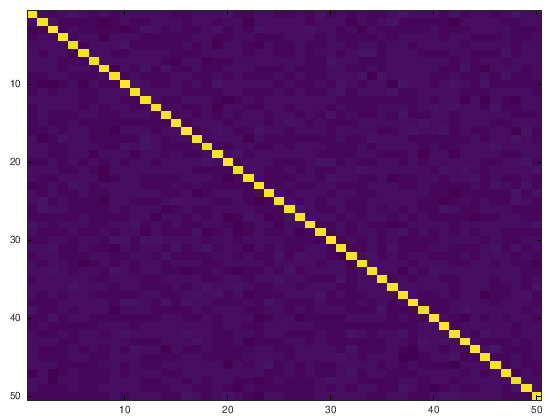

In [59]:
[A, b, x0] = generateData2(300, 3);

figure();
[x, res] = myrgmres(A, b, x0, 150, 1e-10);

figure();
semilogy(res);

figure();
imagesc(A(1:50, 1:50));

x_true = A\b;
norm(x_true-x, 2)

🚀 Raggiunta Tolleranza, stop
ans =  1.1308


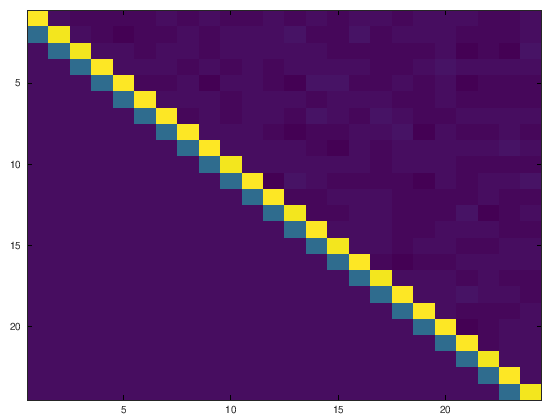

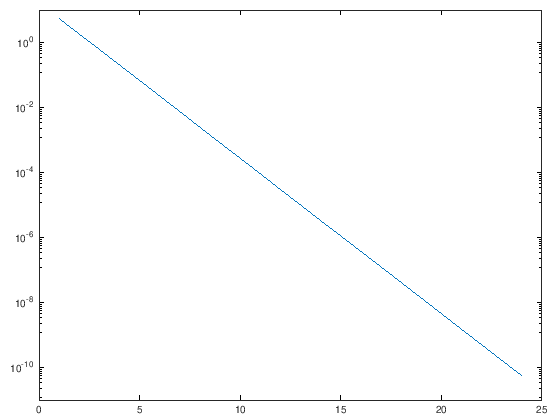

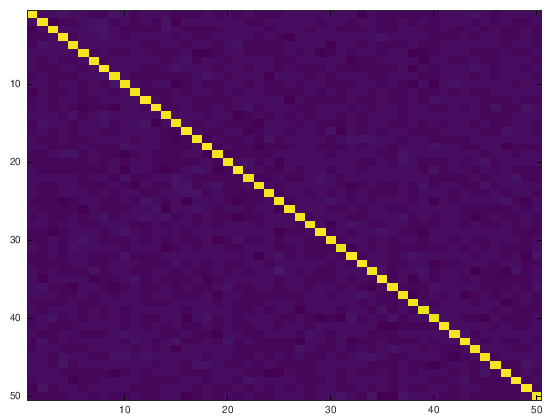

In [58]:
[A, b, x0] = generateData2(300, 3);

figure();
[x, res] = myrgmres(A, b, x0, 150, 1e-10, 10);

figure();
semilogy(res);

figure();
imagesc(A(1:50, 1:50));

x_true = A\b;
norm(x_true-x, 2)

🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🚀 Raggiunta Tolleranza, stop


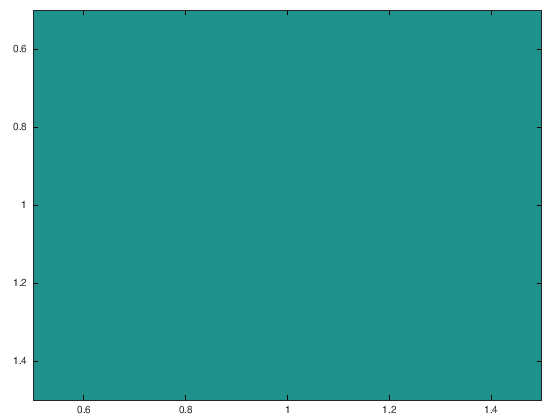

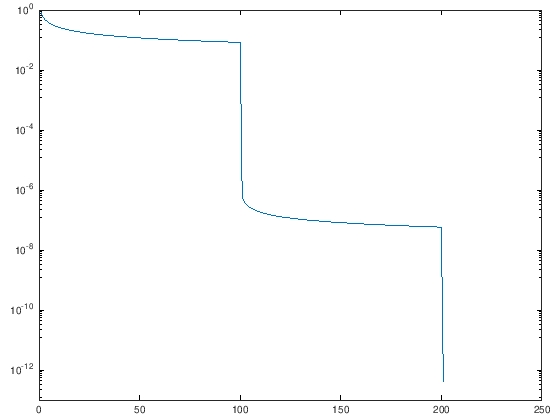

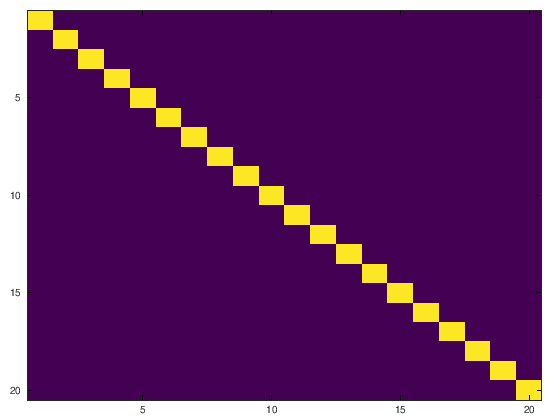

In [17]:
A = eye(10000)*120;

figure();
[x, res] = myrgmres(A, b, x0, 100, 1e-10, 10);

figure();
semilogy(res);

figure();
imagesc(A(1:50, 1:50));
% A(1:10, 1:10)

🚀 Raggiunta Tolleranza, stop


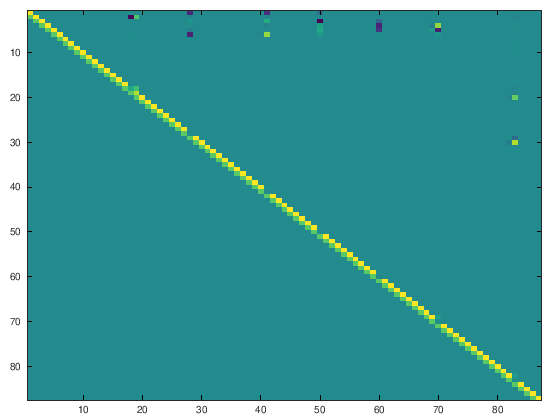

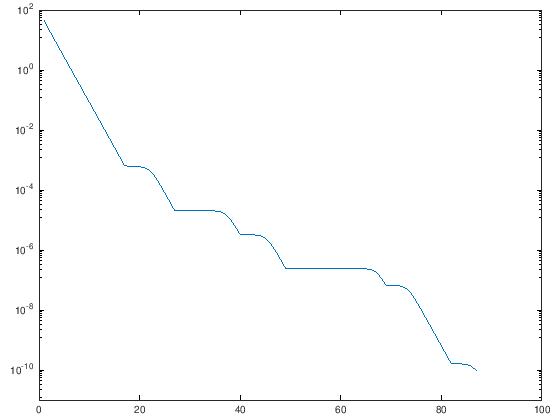

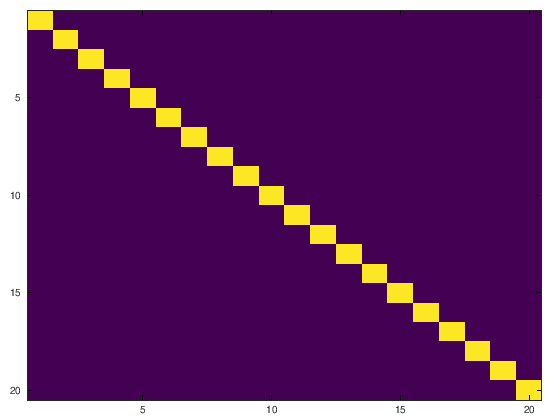

In [18]:
A = (ones(10000)-0.999999999999) + eye(10000)*2;

figure();
[x, res] = myrgmres(A, b, x0, 100, 1e-10, 10);

figure();
semilogy(res);

figure();
imagesc(A(1:50, 1:50));
% A(1:10, 1:10)

🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🚀 Raggiunta Tolleranza, stop


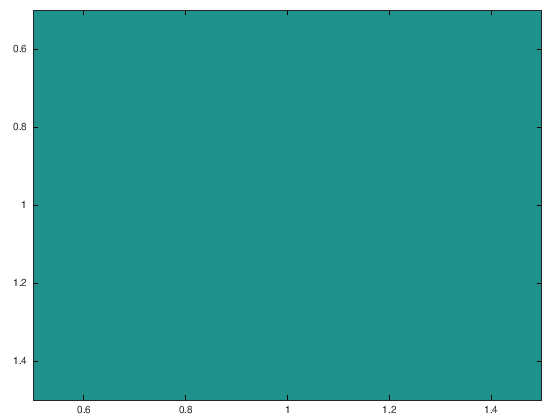

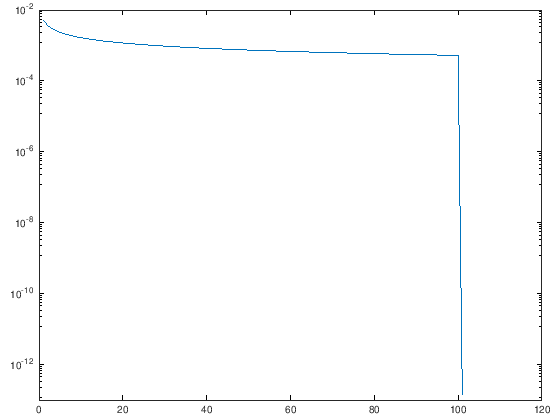

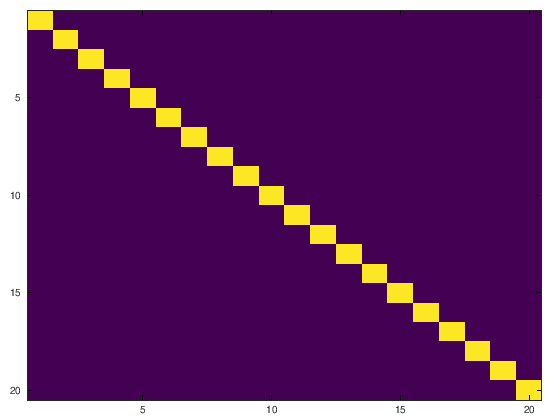

In [19]:
A = (ones(10000)+.9) + eye(10000)*3;

figure();
[x, res] = myrgmres(A, b, x0, 100, 1e-10, 10);

figure();
semilogy(res);

figure();
imagesc(A(1:50, 1:50));
% A(1:10, 1:10)

🍌 n = -4
🚀 Raggiunta Tolleranza, stop
approx_error =  0.10354
normm =  1.8805
🍌 n = -2
🚀 Raggiunta Tolleranza, stop
approx_error =  0.41524
normm =  4.1312
🍌 n = 0
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo numero di Iterazioni
🗿 Restarting ...
🐌 Raggiunto massimo nume

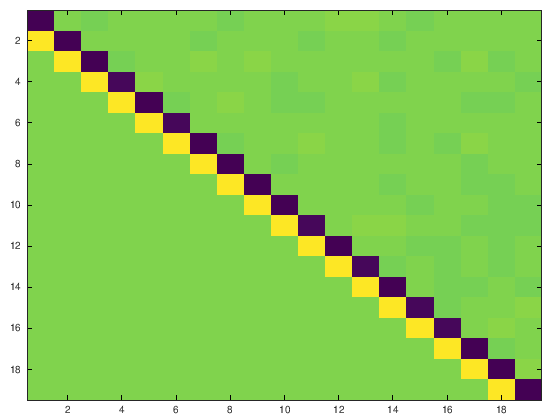

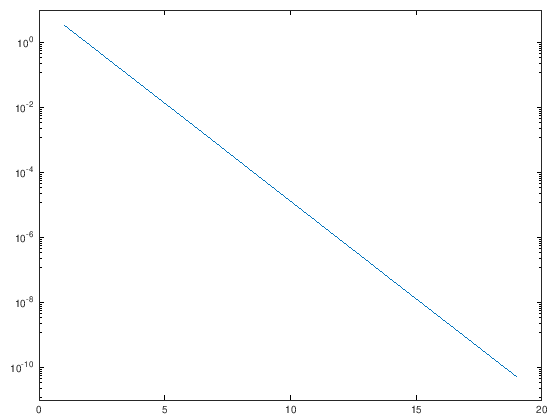

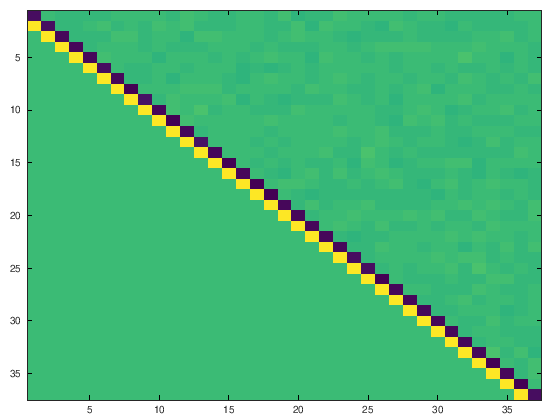

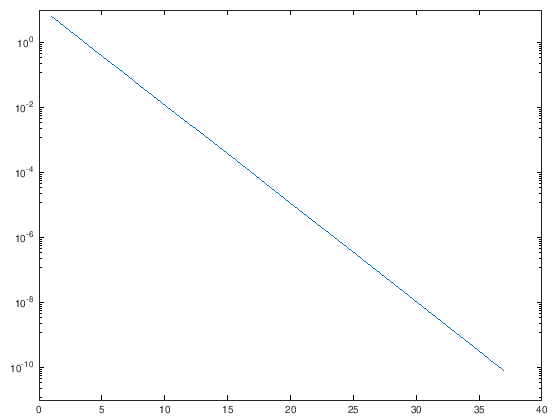

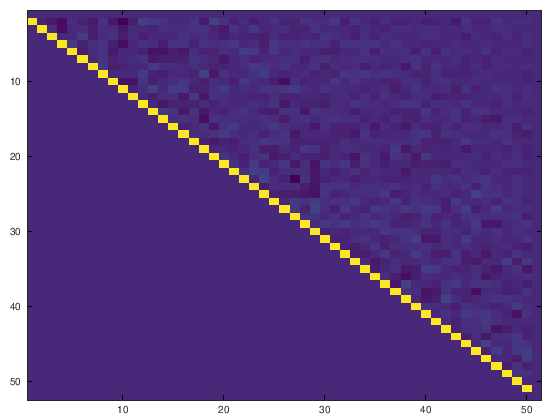

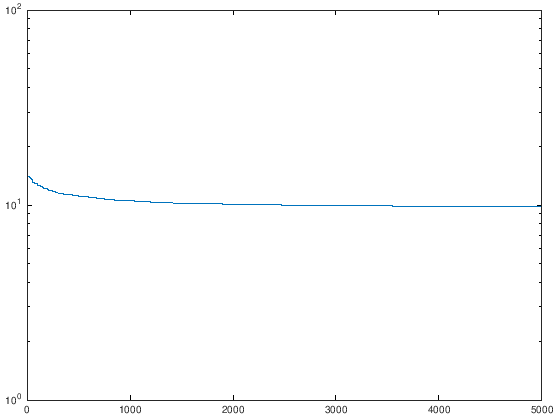

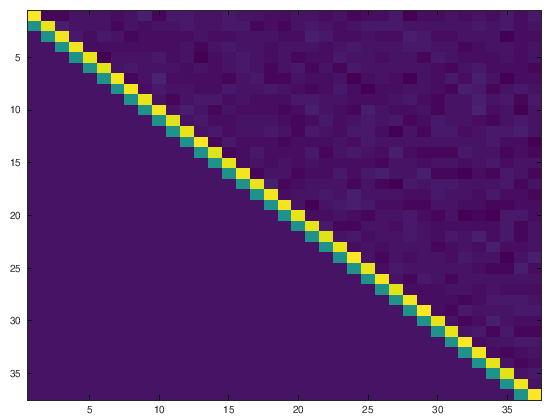

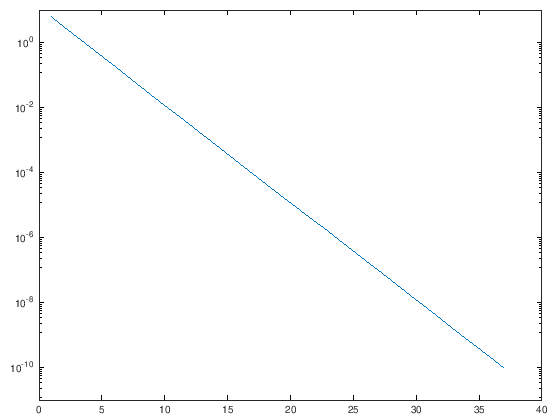

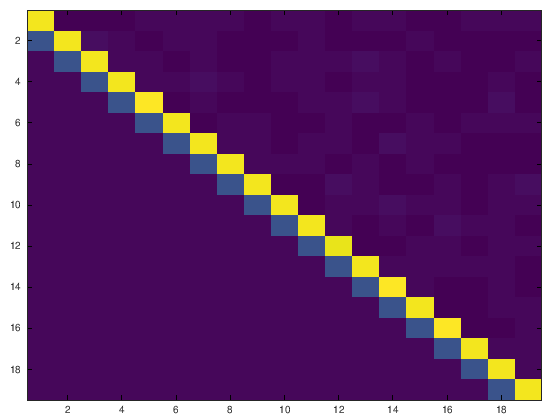

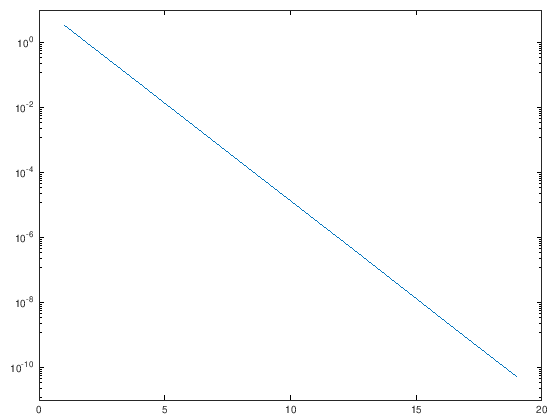

In [20]:
for n = [-4 -2 0 2 4]
    figure();
    printf("🍌 n = %d\n", n)
    [A, b, x0] = generateData2(200, n=n);
    [x, res] = myrgmres(A, b, x0, 50, 1e-10, 100);
    
    % x;
    x_true = A\b;
    approx_error = max(x_true-x)
    normm = norm(A*x - b)
    
    figure();
    title(["GMRES with n = " mat2str(n)]);
    semilogy(res);
end